# Notebook to make Fig. 5

In [1]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
from scipy.stats import gaussian_kde

import json
import random

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style

from helper_functions import *

style.use('plotting.mplstyle')

In [2]:
# TODO: create drawChiEff script
sys.path.append('/home/zoe.ko/LIGOSURF22/scripts/')
from drawChiEff import *

### Load data

In [3]:
# location of emcee samples
data_folder = '/home/simona.miller/comp-spin-mock-injections/Data/PopulationInferenceOutput/betaPlusGaussian/'
model = 'betaPlusGaussian'
numinjections = 70

all_data = []
for pop in np.array([1, 2, 3]):
    pop = str(pop)
    
    name = f'{data_folder}betaPlusGaussian_pop{pop}_{numinjections}events_temp'
    with open(f'{name}.json', 'r') as f:
        pop_data = json.load(f)
        all_data += [pop_data]

In [4]:
# location of reweighted sample dicts (output of running posterior_reweighting)
rw_folder = '/home/zoe.ko/comp-spin-mock-injections/Data/PopulationInferenceOutput/betaPlusGaussian/'

### Do posteriors reweighting

In [5]:
labels_dict = {
    'pop1':r'$\mathrm{\textsc{HighSpinPrecessing}}$', 
    'pop2':r'$\mathrm{\textsc{MediumSpin}}$', 
    'pop3':r'$\mathrm{\textsc{LowSpinAligned}}$'
}

/home/zoe.ko/comp-spin-mock-injections/Figures/./../Code/PopulationInference/posterior_helper_functions.py:227: RuntimeWarning: overflow encountered in exp
  f = np.exp(deltaM/m + deltaM/(m-deltaM))


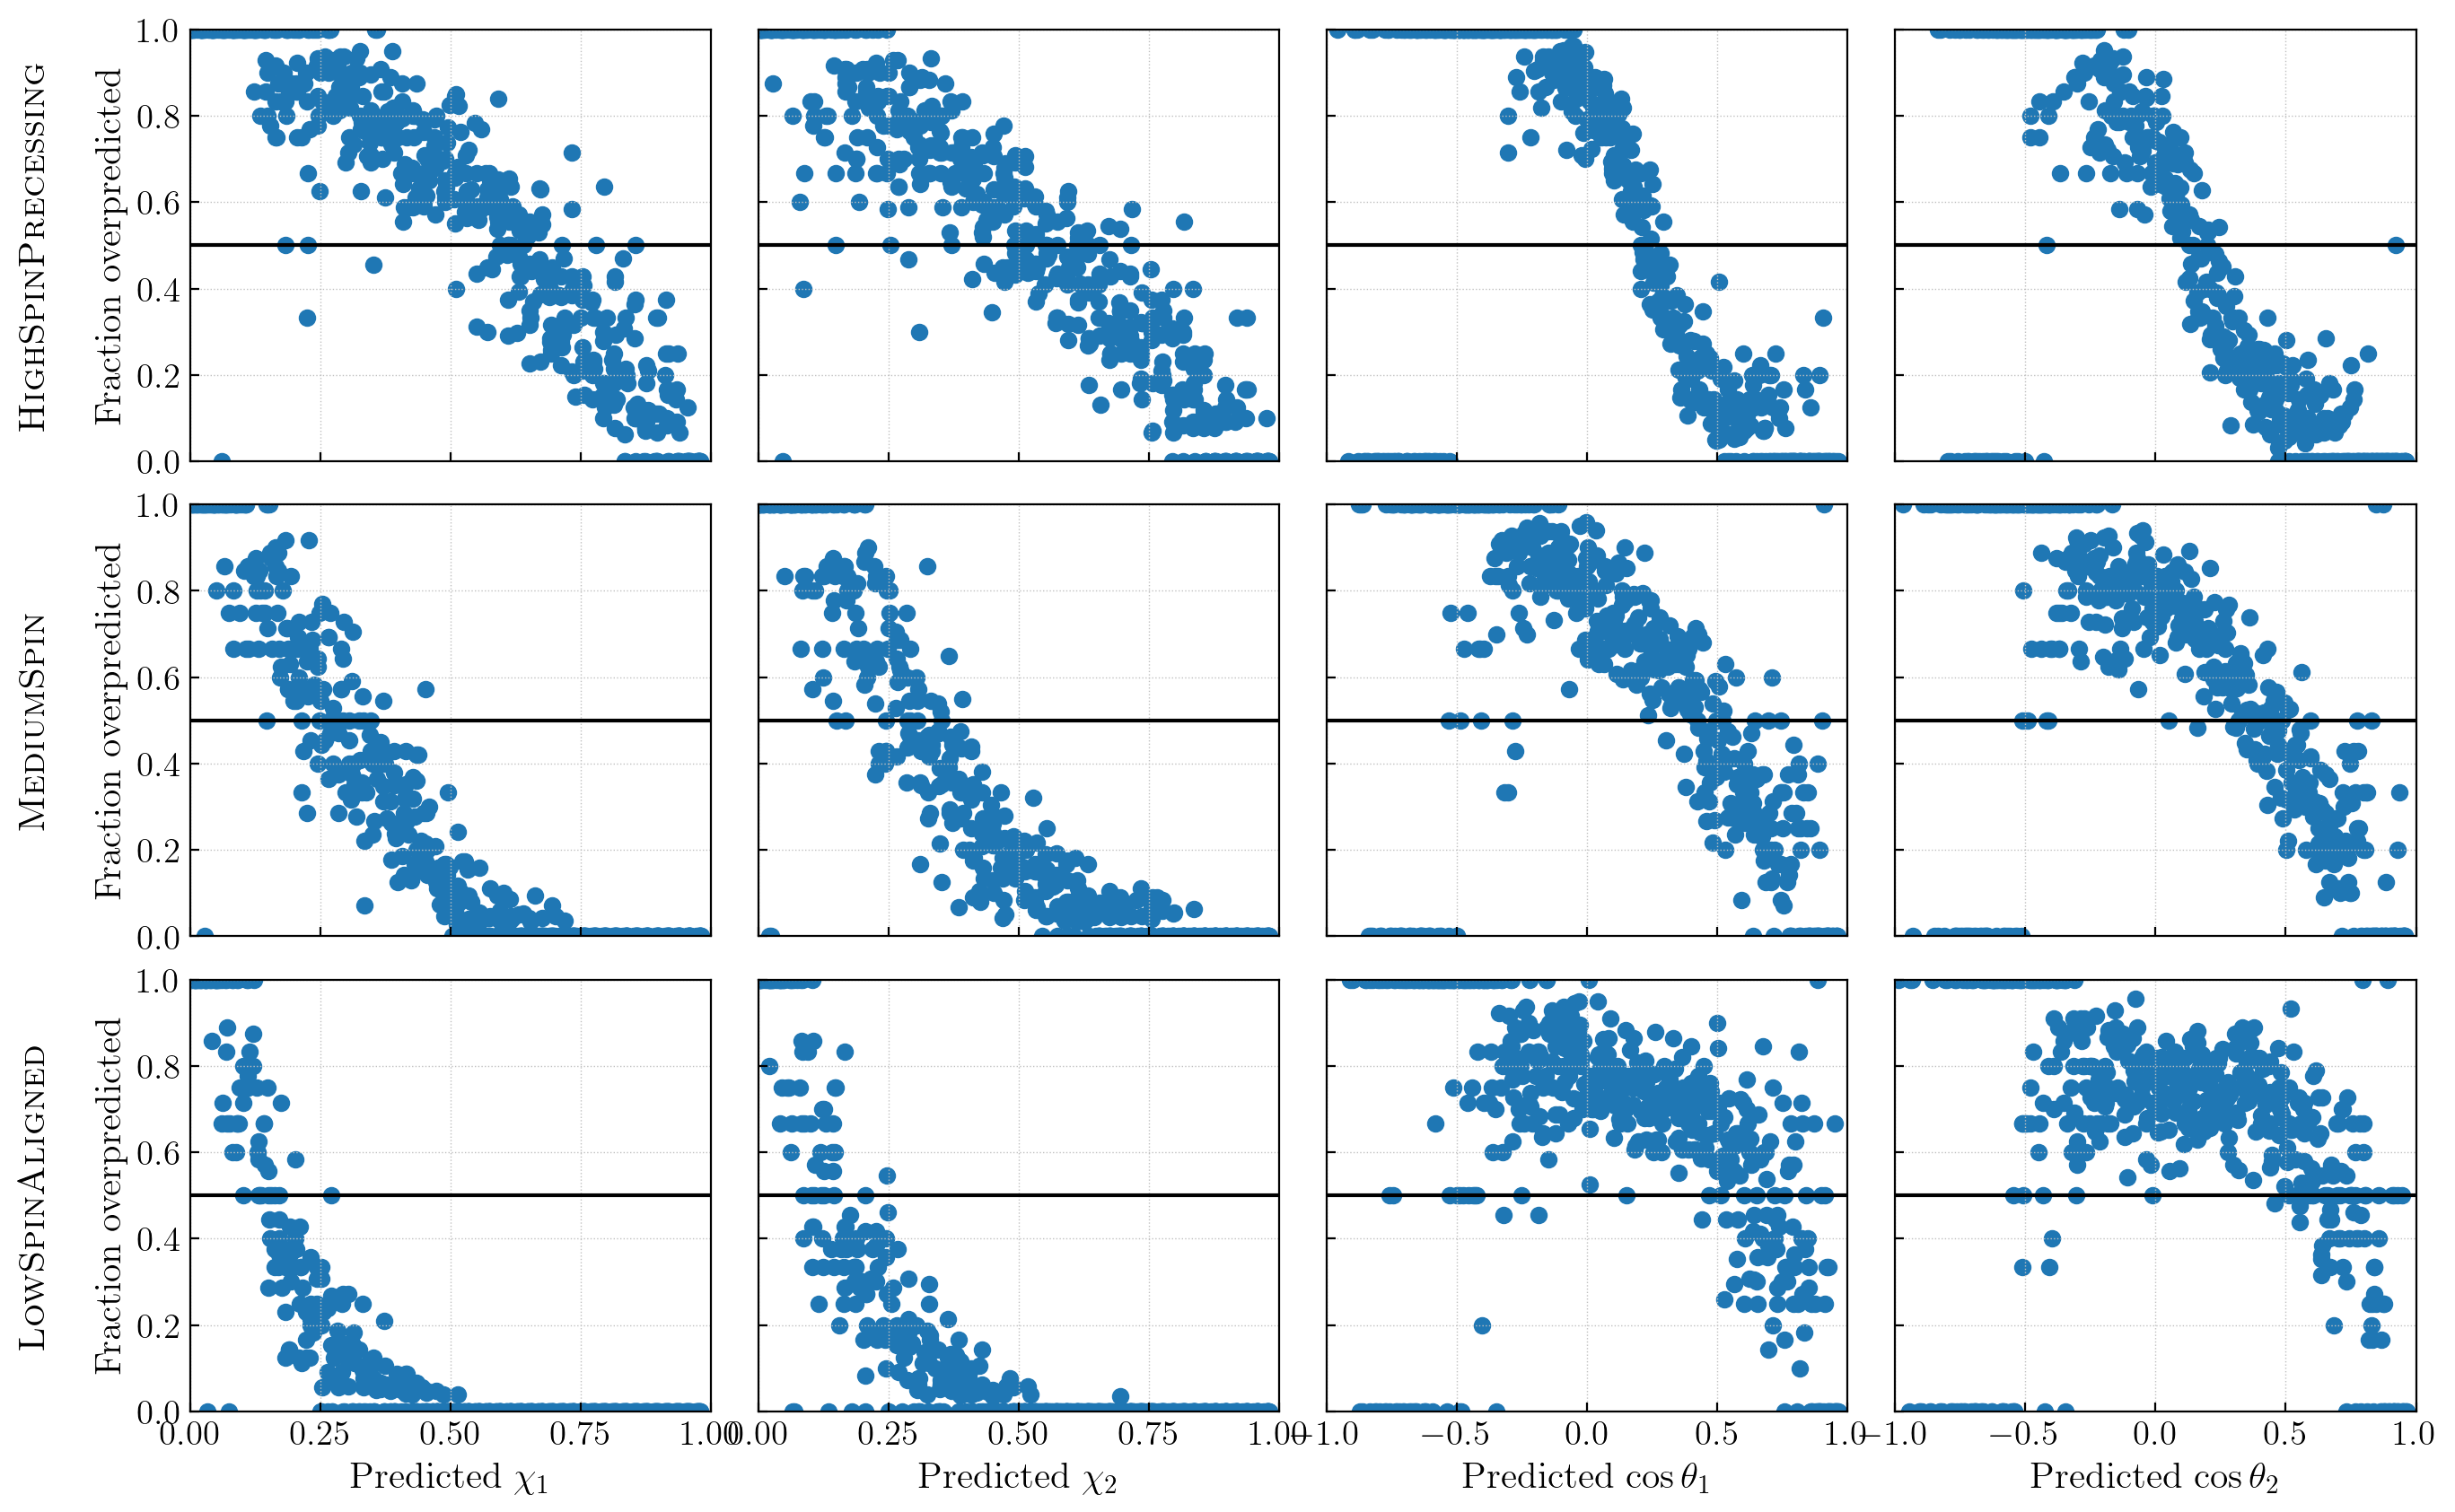

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,10))
rotate_axis=False

for pop,pop_key in enumerate(['pop1', 'pop2', 'pop3']):

    # final pp plot data for all four parameters
    chi1_all_num_bins = []
    chi1_all_percentages = []

    chi2_all_num_bins = []
    chi2_all_percentages = []

    cost1_all_num_bins = []
    cost1_all_percentages = []

    cost2_all_num_bins = []
    cost2_all_percentages = []


    for i in np.arange(10):
        all_chi1_pred = []
        all_chi2_pred = []
        all_cost1_pred = []
        all_cost2_pred = []
        all_chieff_pred = []

        all_chi1_obs = []
        all_chi2_obs = []
        all_cost1_obs = []
        all_cost2_obs = []
        all_chieff_obs = []

        for runs in np.arange(10):

            data = all_data[0]

            chi1_pred = []
            chi2_pred = []
            cost1_pred = []
            cost2_pred = []
            chieff_pred = []

            # Define a grid of effective spins
            chi_grid = np.linspace(0,1,1000)
            cost_grid = np.linspace(-1,1,1000)

            # Choose a number of traces to draw
            nTraces = 70
            n = 1

            # Instantiate an array to hold a collection of traces
            p_chi = np.zeros((nTraces,chi_grid.size))
            p_cost = np.zeros((nTraces,cost_grid.size))
            chieff_kdes_on_grid = np.zeros((nTraces,cost_grid.size))

            # For a random set of posterior samples, compute and store the corresponding probability densities across our grid
            random_indices = np.random.choice(np.arange(len(data['mu_chi']['processed'])), size=nTraces,replace=False)
            for i,ind in enumerate(random_indices):

                mu_chi = data['mu_chi']['processed'][ind]
                sigma_chi = data['sigma_chi']['processed'][ind]
                mu_cost = data['mu_cost']['processed'][ind]
                sigma_cost = data['sigma_cost']['processed'][ind]
                Bq = data['Bq']['processed'][ind]

                # calculate Gaussian distribution for chi
                p_chi[i,:] = calculate_Gaussian_1D(chi_grid, mu_chi, sigma_chi, -1, 1)

                # and Gaussian distribution for cos(theta)
                p_cost[i,:] = calculate_Gaussian_1D(cost_grid, mu_cost, sigma_cost, -1, 1)

                # draw uniform component spins + masses
                nRandomDraws = 10000
                samp_idxs = np.arange(nRandomDraws)
                chi1s = np.random.rand(nRandomDraws)
                chi2s = np.random.rand(nRandomDraws)
                cost1s = np.random.rand(nRandomDraws)*2 - 1
                cost2s = np.random.rand(nRandomDraws)*2 - 1
                mAs = np.random.rand(nRandomDraws)*100
                mBs = np.random.rand(nRandomDraws)*100
                m1s = np.maximum(mAs, mBs)
                m2s = np.minimum(mAs, mBs)


                p_chi1 = calculate_Gaussian_1D(chi1s, mu_chi, sigma_chi, 0, 1)
                p_chi2 = calculate_Gaussian_1D(chi2s, mu_chi, sigma_chi, 0, 1)
                p_cost1 = calculate_Gaussian_1D(cost1s, mu_cost, sigma_cost, -1, 1)
                p_cost2 = calculate_Gaussian_1D(cost2s, mu_cost, sigma_cost, -1, 1)
                p_masses = p_astro_masses(m1s, m2s, bq=Bq)

                weights = p_chi1*p_chi2*p_cost1*p_cost2*p_masses
                weights_normed = weights/np.sum(weights)
                weights_normed[np.where(weights_normed<0)] = 0 # get rid of tiny division errors

                # select a subset of the samples subject to the weights
                # calculated from p(spins,masses)
                idxs = np.random.choice(samp_idxs, p=weights_normed, size=n)  

                # calculate chi-eff for these samples
                q = m2s[idxs]/m1s[idxs]
                chi_eff = (chi1s[idxs]*cost1s[idxs] + q*chi2s[idxs]*cost2s[idxs])/(1+q)

                chi1 = chi1s[idxs]
                chi2 = chi2s[idxs]
                cost1 = cost1s[idxs]
                cost2 = cost2s[idxs]

                chi1_pred = np.append(chi1_pred, chi1)
                chi2_pred = np.append(chi2_pred, chi2)
                cost1_pred = np.append(cost1_pred, cost1)
                cost2_pred = np.append(cost2_pred, cost2)
                chieff_pred = np.append(chieff_pred, chi_eff)



                # draw 500 chi-effective samples corresponding to the component spin distributions with hyper-parameters
                # {mu_chi, sigma_chi, MF_cost, sigma_cost, f_spike, sigma_spike, zmin, Bq,}
                chi_effs = drawChieffsGauss(mu_chi, sigma_chi, mu_cost, sigma_cost, -1, Bq, n=500)

                # calculate KDE from these draws and evaluate them on a grid of chi-effective values (i.e. chieff_grid = 
                # np.linspace(-1,1,100)
                chieff_grid = np.linspace(-1,1,1000)
                chieff_kde = gaussian_kde(chi_effs)
                chieff_kdes_on_grid[i,:] = chieff_kde(chieff_grid)


            sampleDict_rw = np.load(rw_folder + str(numinjections) + model + '_' + 'pop' + str(pop+1)
                                    + 'rw_sampleDict.pickle', allow_pickle=True)
            chi1_obs = []
            chi2_obs = []
            cost1_obs = []
            cost2_obs = []
            chieff_obs = []

            for key in sampleDict_rw.keys():
                d = sampleDict_rw[key]
                chi1 = random.choice(d['chi1'])
                chi1_obs += [chi1]
                chi2 = random.choice(d['chi2'])
                chi2_obs += [chi2]
                cost1 = random.choice(d['cost1'])
                cost1_obs += [cost1]
                cost2 = random.choice(d['cost2'])
                cost2_obs += [cost2]



            if rotate_axis == True:
                all_chi1_pred += [np.sort(chi1_pred)]
                all_chi2_pred += [np.sort(chi2_pred)]
                all_cost1_pred += [np.sort(cost1_pred)]
                all_cost2_pred += [np.sort(cost2_pred)]
                all_chieff_pred += [chieff_pred]

                all_chi1_obs += [np.sort(chi1_obs) - np.sort(chi1_pred)]
                all_chi2_obs += [np.sort(chi2_obs) - np.sort(chi2_pred)]
                all_cost1_obs += [np.sort(cost1_obs) - np.sort(cost1_pred)]
                all_cost2_obs += [np.sort(cost2_obs) - np.sort(cost2_pred)]
                all_chieff_obs += [chieff_obs]

            else:
                all_chi1_pred += [chi1_pred]
                all_chi2_pred += [chi2_pred]
                all_cost1_pred += [cost1_pred]
                all_cost2_pred += [cost2_pred]
                all_chieff_pred += [chieff_pred]

                all_chi1_obs += [chi1_obs]
                all_chi2_obs += [chi2_obs]
                all_cost1_obs += [cost1_obs]
                all_cost2_obs += [cost2_obs]
                all_chieff_obs += [chieff_obs]

        # no interpolation - just binning

        # chi1
        all_x = np.concatenate(all_chi1_pred)
        all_y = np.concatenate(all_chi1_obs)
        numbins = 50
        xmin = np.min(all_x)
        xmax = np.max(all_x)
        numbins = np.linspace(xmin, xmax, numbins)
        # binning
        percentages = []
        for i in np.arange(len(numbins)-1):
            lower_bound = numbins[i]
            upper_bound = numbins[i+1]
            mask = (all_x >= lower_bound) & (all_x <= upper_bound)
            x_vals = all_x[mask]
            y_vals = all_y[mask]
            # percentage of values above y=x
            if len(x_vals) == 0:
                per = 0
            else:
                if rotate_axis==True:
                    per = sum(y_vals > 0) / len(y_vals)
                else:
                    per = sum(y_vals > x_vals) / len(x_vals)
            percentages += [per]
        chi1_all_num_bins += [numbins[:-1]]
        chi1_all_percentages += [percentages]

        # chi2
        all_x = np.concatenate(all_chi2_pred)
        all_y = np.concatenate(all_chi2_obs)
        numbins = 50
        xmin = np.min(all_x)
        xmax = np.max(all_x)
        numbins = np.linspace(xmin, xmax, numbins)
        # binning
        percentages = []
        for i in np.arange(len(numbins)-1):
            lower_bound = numbins[i]
            upper_bound = numbins[i+1]
            mask = (all_x >= lower_bound) & (all_x <= upper_bound)
            x_vals = all_x[mask]
            y_vals = all_y[mask]
            # percentage of values above y=x
            if len(x_vals) == 0:
                per = 0
            else:
                if rotate_axis==True:
                    per = sum(y_vals > 0) / len(y_vals)
                else:
                    per = sum(y_vals > x_vals) / len(x_vals)
            percentages += [per]
        chi2_all_num_bins += [numbins[:-1]]
        chi2_all_percentages += [percentages]

        # cost1
        all_x = np.concatenate(all_cost1_pred)
        all_y = np.concatenate(all_cost1_obs)
        numbins = 50
        xmin = np.min(all_x)
        xmax = np.max(all_x)
        numbins = np.linspace(xmin, xmax, numbins)
        # binning
        percentages = []
        for i in np.arange(len(numbins)-1):
            lower_bound = numbins[i]
            upper_bound = numbins[i+1]
            mask = (all_x >= lower_bound) & (all_x <= upper_bound)
            x_vals = all_x[mask]
            y_vals = all_y[mask]
            # percentage of values above y=x
            if len(x_vals) == 0:
                per = 0
            else:
                if rotate_axis==True:
                    per = sum(y_vals > 0) / len(y_vals)
                else:
                    per = sum(y_vals > x_vals) / len(x_vals)
            percentages += [per]
        cost1_all_num_bins += [numbins[:-1]]
        cost1_all_percentages += [percentages]

        # cost2
        all_x = np.concatenate(all_cost2_pred)
        all_y = np.concatenate(all_cost2_obs)
        numbins = 50
        xmin = np.min(all_x)
        xmax = np.max(all_x)
        numbins = np.linspace(xmin, xmax, numbins)
        # binning
        percentages = []
        for i in np.arange(len(numbins)-1):
            lower_bound = numbins[i]
            upper_bound = numbins[i+1]
            mask = (all_x >= lower_bound) & (all_x <= upper_bound)
            x_vals = all_x[mask]
            y_vals = all_y[mask]
            # percentage of values above y=x
            if len(x_vals) == 0:
                per = 0
            else:
                if rotate_axis==True:
                    per = sum(y_vals > 0) / len(y_vals)
                else:
                    per = sum(y_vals > x_vals) / len(x_vals)
            percentages += [per]
        cost2_all_num_bins += [numbins[:-1]]
        cost2_all_percentages += [percentages]

    # spin magnitudes
    axes[pop][0].plot([0, 1], [0.5, 0.5], color='k') # diagonal line
    axes[pop][0].scatter(chi1_all_num_bins, chi1_all_percentages)
    axes[pop][0].set_xlim(0,1)
    axes[pop][0].set_ylim(0,1)

    axes[pop][1].plot([0, 1], [0.5, 0.5], color='k')
    axes[pop][1].scatter(chi2_all_num_bins, chi2_all_percentages)
    axes[pop][1].set_xlim(0,1)
    axes[pop][1].set_ylim(0,1)

    # tilt angles
    axes[pop][2].plot([-1, 1], [0.5, 0.5], color='k')
    axes[pop][2].scatter(cost1_all_num_bins, cost1_all_percentages)
    axes[pop][2].set_xlim(-1,1)
    axes[pop][2].set_ylim(0,1)

    axes[pop][3].plot([-1, 1], [0.5, 0.5], color='k')
    axes[pop][3].scatter(cost2_all_num_bins, cost2_all_percentages)
    axes[pop][3].set_xlim(-1,1)
    axes[pop][3].set_ylim(0,1)

    # set label
    axes[pop][0].set_ylabel(f'{labels_dict[pop_key]}\n\n Fraction overpredicted', fontsize=15)

    if pop!=2: 
        for ax in axes[pop]: 
            ax.set_xticklabels([])
            
axes[2][0].set_xlabel(r'Predicted $\chi_1$', fontsize=15)
axes[2][1].set_xlabel(r'Predicted $\chi_2$', fontsize=15)
axes[2][2].set_xlabel(r'Predicted $\cos\theta_1$', fontsize=15)
axes[2][3].set_xlabel(r'Predicted $\cos\theta_2$', fontsize=15)

for ax in axes: 
    for i,a in enumerate(ax):
        a.grid(ls=':', color='silver', lw=0.5)
        if i!=0: 
            a.set_yticklabels([])
        
plt.subplots_adjust(hspace=0.1, wspace=0.09)
    
plt.savefig('figure_05_temp.pdf',bbox_inches='tight')
plt.show()

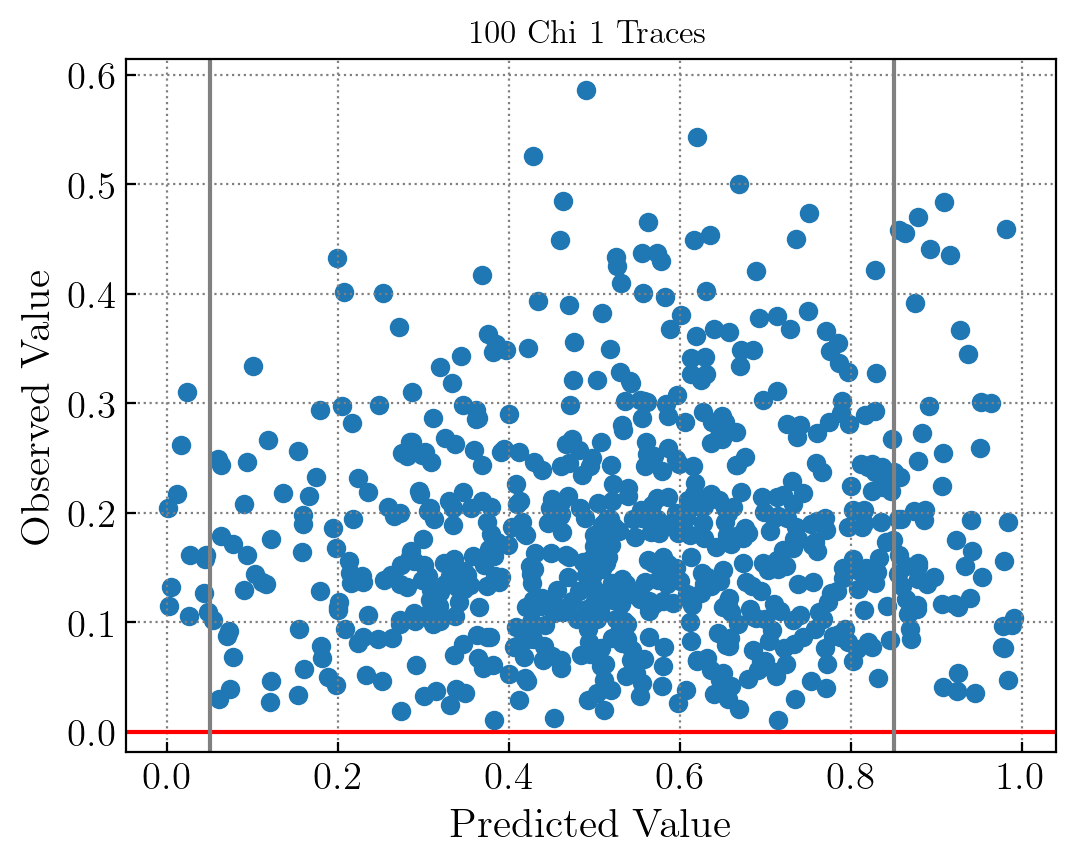

In [9]:
plt.scatter(all_chi1_pred, all_chi1_obs)
plt.axhline(y=0, label='y=0', color='red')
plt.axvline(x=0.05, color='gray')
plt.axvline(x=0.85, color='gray')
plt.xlabel('Predicted Value', fontsize=15)
plt.ylabel('Observed Value', fontsize=15)
plt.title('100 Chi 1 Traces')
plt.show()

### Make figure

In [7]:
labels_dict = {
    'pop1':r'$\mathrm{\textsc{HighSpinPrecessing}}$', 
    'pop2':r'$\mathrm{\textsc{MediumSpin}}$', 
    'pop3':r'$\mathrm{\textsc{LowSpinAligned}}$'
}

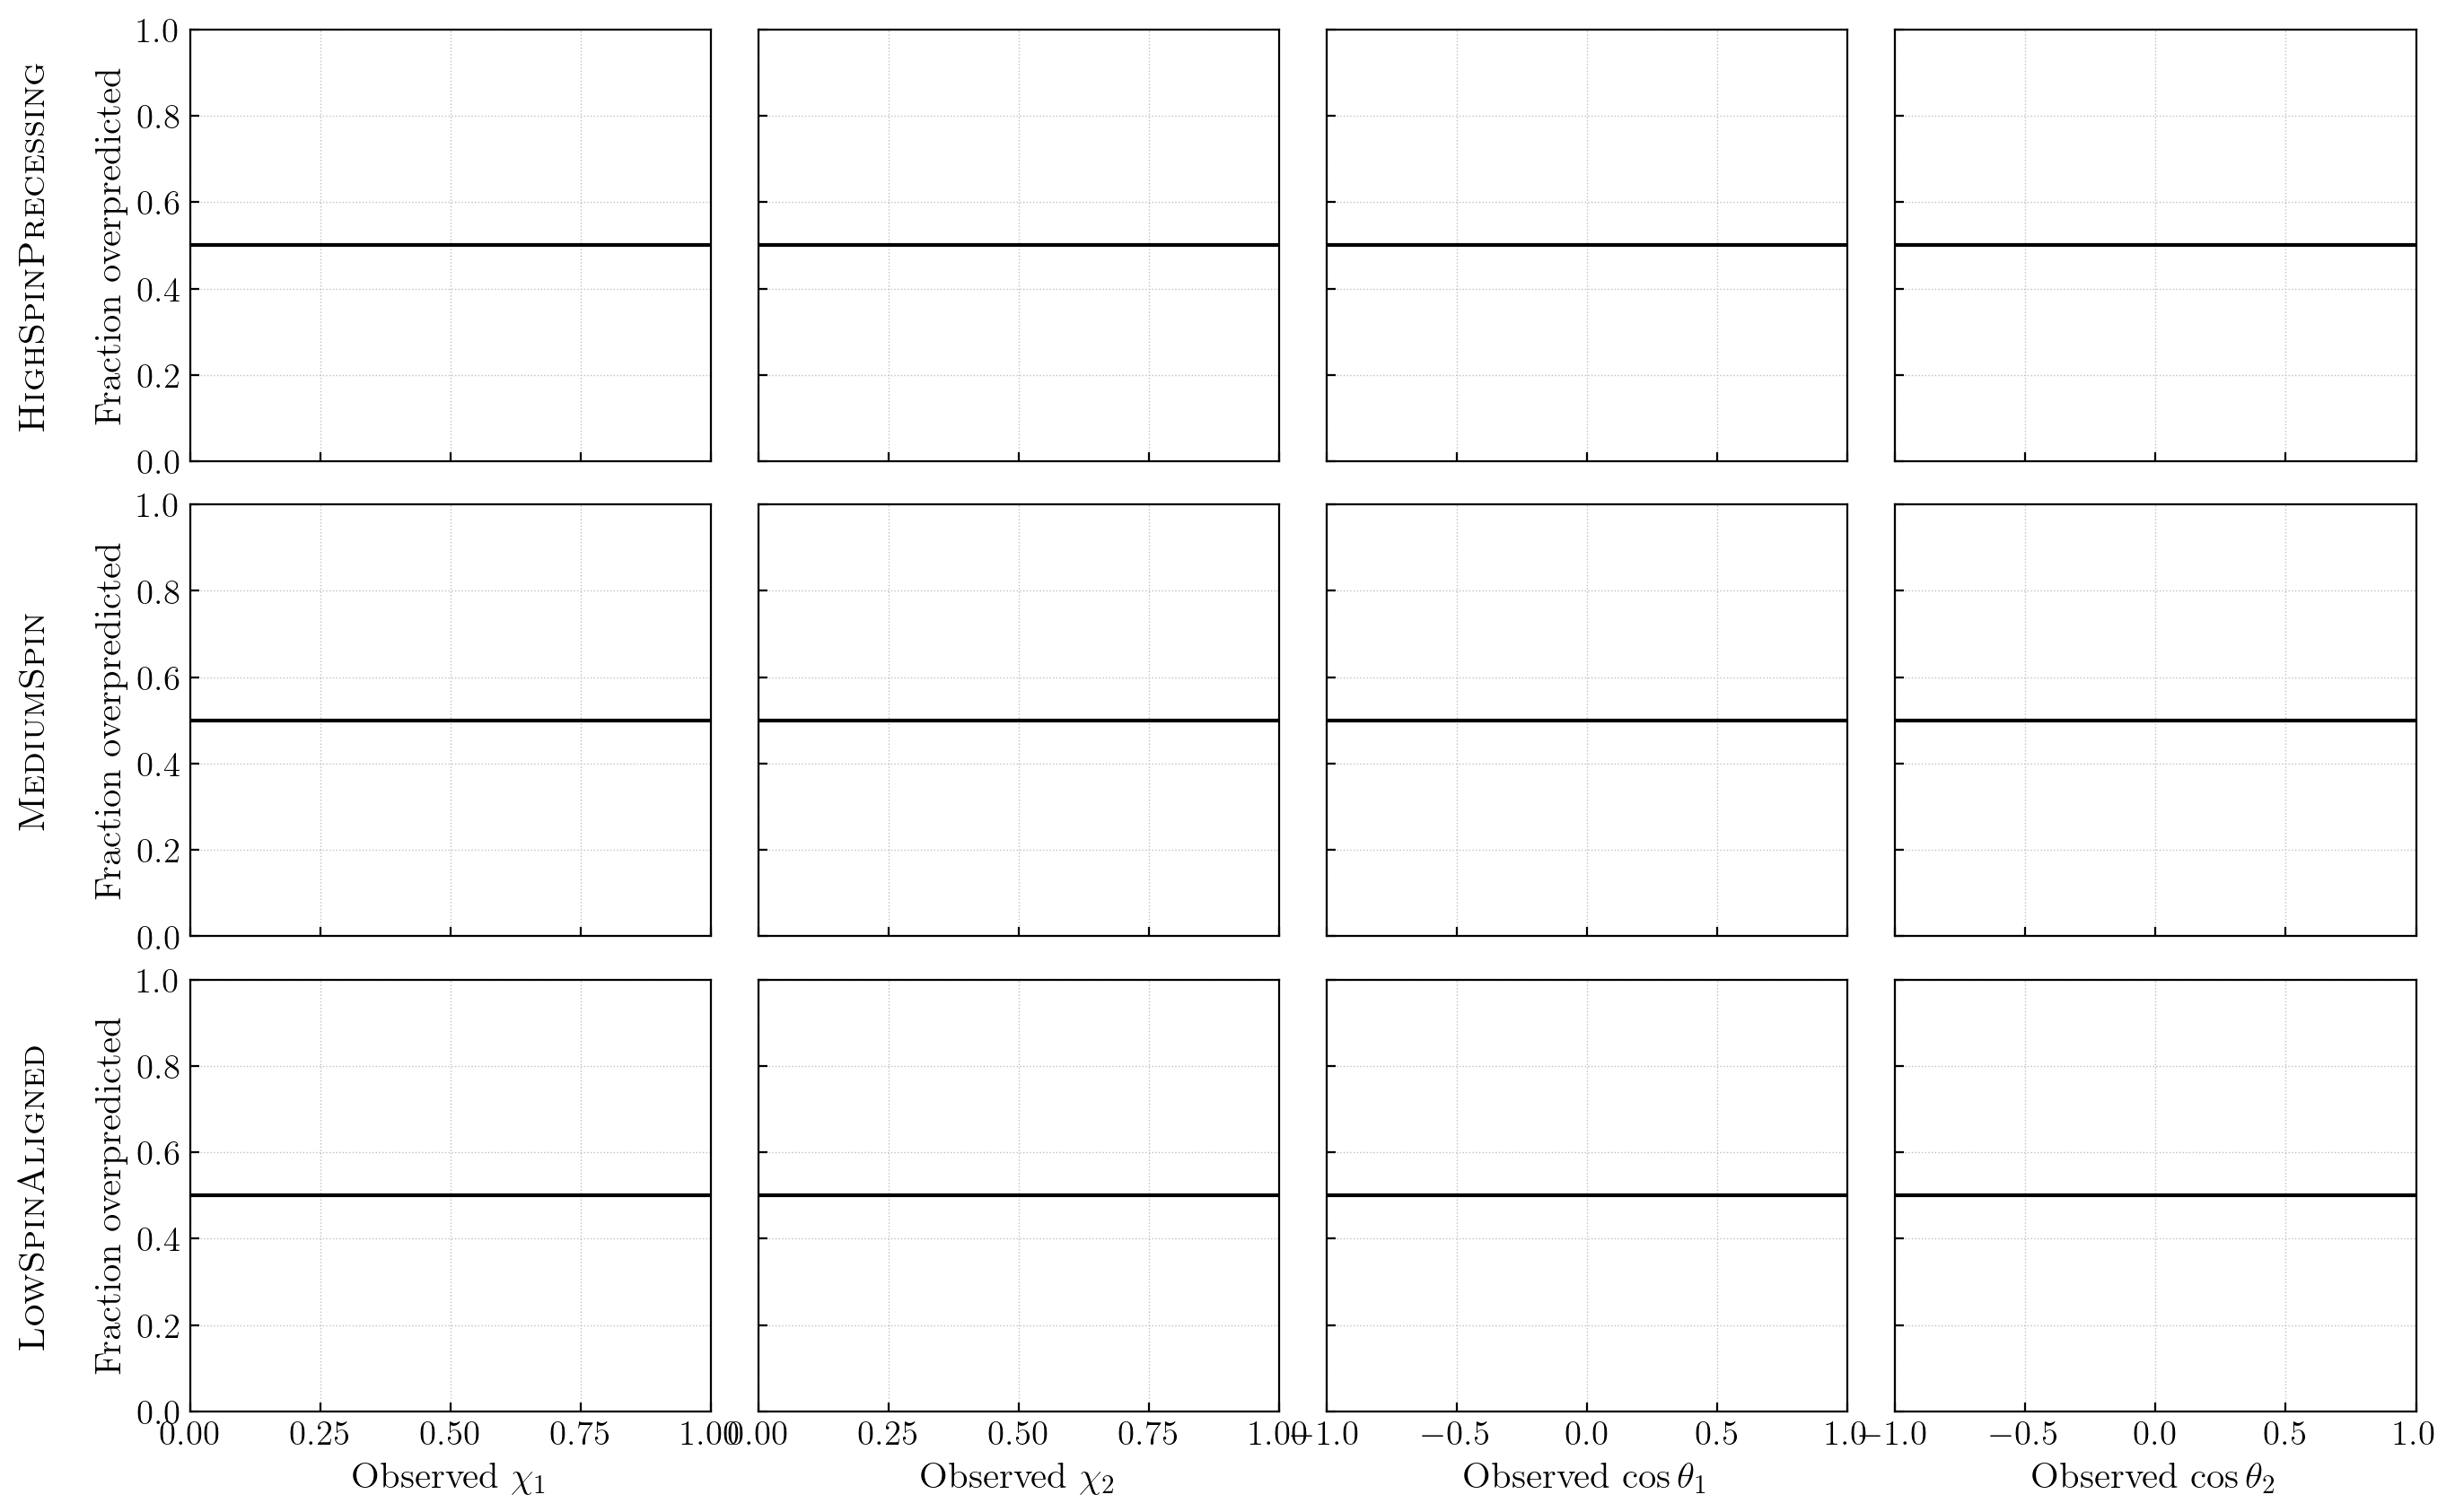

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,10))

for i,key in enumerate(['pop1', 'pop2', 'pop3']):
    
    # spin magnitudes
    axes[i][0].plot([0, 1], [0.5, 0.5], color='k') # diagonal line
    axes[i][0].set_xlim(0,1)
    axes[i][0].set_ylim(0,1)
    
    axes[i][1].plot([0, 1], [0.5, 0.5], color='k')
    axes[i][1].set_xlim(0,1)
    axes[i][1].set_ylim(0,1)
    
    # tilt angles
    axes[i][2].plot([-1, 1], [0.5, 0.5], color='k')
    axes[i][2].set_xlim(-1,1)
    axes[i][2].set_ylim(0,1)
    
    axes[i][3].plot([-1, 1], [0.5, 0.5], color='k')
    axes[i][3].set_xlim(-1,1)
    axes[i][3].set_ylim(0,1)
    
    # set label
    axes[i][0].set_ylabel(f'{labels_dict[key]}\n\n Fraction overpredicted', fontsize=15)
        
    if i!=2: 
        for ax in axes[i]: 
            ax.set_xticklabels([])
    
axes[2][0].set_xlabel(r'Observed $\chi_1$', fontsize=15)
axes[2][1].set_xlabel(r'Observed $\chi_2$', fontsize=15)
axes[2][2].set_xlabel(r'Observed $\cos\theta_1$', fontsize=15)
axes[2][3].set_xlabel(r'Observed $\cos\theta_2$', fontsize=15)

for ax in axes: 
    for i,a in enumerate(ax):
        a.grid(ls=':', color='silver', lw=0.5)
        if i!=0: 
            a.set_yticklabels([])
        
plt.subplots_adjust(hspace=0.1, wspace=0.09)
    
plt.savefig('figure_05_temp.pdf',bbox_inches='tight')
plt.show()